# Evaluate the bias of aperture effect on the pulse duration 
2024.3.12 Kurama Okubo

We evaluate the effect of aperture effect on the observed pulse width.

In [1]:
import os
import obspy
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
import math
import pandas as pd
from tqdm import tqdm
import warnings
from scipy import integrate
import scipy

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# import functions
from AE_surf_numintegral_func import *
from scipy.optimize import minimize, Bounds


%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

208.7951761042903 0.28601023091343925
95.84777463001969 0.24780544695306414 38.406538


In [2]:
figdir = "./figure"
if not os.path.exists(figdir):
    os.makedirs(figdir)

We numerically integrate the following formulation:

- Cosine STF
$$
s(t, \theta, \mathbf{r}) =
\begin{cases}
    \dfrac{M_0}{T_R}\left[1-\cos \dfrac{2\pi (t + r \cos \phi / v_a)}{T_R} \right], & \text{for}~0 < t + r \cos \phi / v_a < T_R  \\ 
     0, & \text{else}. \\
  \end{cases}
$$

- Balldrop STF

$$ s(t, \theta, \mathbf{r}) =
\begin{cases}
    \sin^{3/2}\left(\dfrac{\pi (t + r \cos \phi / v_a)}{T_R} \right), & \text{for}~0 < t + r \cos \phi / v_a < T_R  \\ 
     0, & \text{else}. \\
  \end{cases}
$$
  
$$ y(t, \theta) = \dfrac{1}{\pi R^2} \int_{0}^{2\pi} \int_{0}^{R}  s(t, \theta, \mathbf{r})  rdrd\phi. $$

We assume that the amplitude sensitivity of the sensor surface is uniform.

## Comparison of the source time function between cosine and $\sin^{3/2}$

In [3]:
def stf_cosine(t, TR, fz):
    '''
        source time function of cosine wavelet
        https://tktmyd.github.io/OpenSWPC/English/2._Parameter_Settings/0207_source/
        Argument: 
            t:: time vector
    '''
    stf = np.zeros(len(t))
    for i, tt in enumerate(t):
        if 0<tt and tt<TR:
            stf[i] = (fz/TR) * (1 - np.cos((2*np.pi*tt/TR)))
        else:
            stf[i] = 0
            
    return stf

def stf_herzian_mclaskey2009_scaled(t, TR):
    stf = np.zeros(len(t))
    for i, tt in enumerate(t):
        if 0<tt and tt < TR:
            stf[i] = (np.sin(np.pi*tt/TR))**(3/2)
        else:
            stf[i] = 0
            
    return stf

In [4]:
dt = 1e-7 # synchronized to the 10Mhz same as the experiments
tvec  = np.arange(-1e-5, 1e-5,step=dt)

In [5]:
TR_try = 3e-6
stf_cos = stf_cosine(tvec, TR_try, 1)
stf_bd = stf_herzian_mclaskey2009_scaled(tvec, TR_try)

(-1e-05, 1e-05)

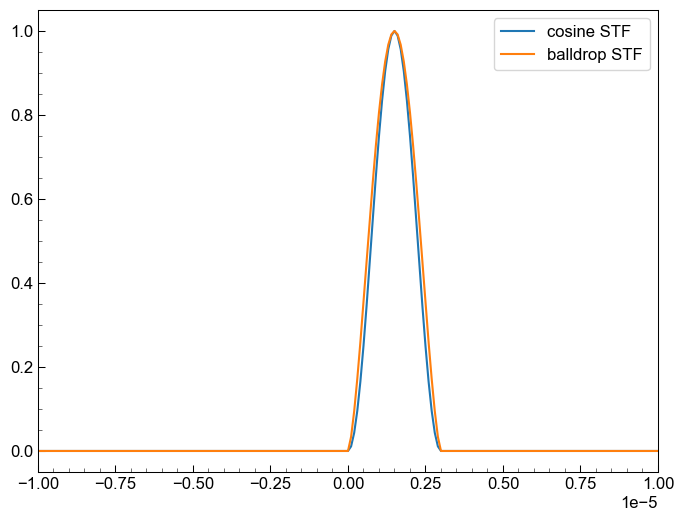

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(tvec, stf_cos/np.max(stf_cos), label="cosine STF")
ax.plot(tvec, stf_bd, label="balldrop STF")
ax.legend(loc=1)
ax.set_xlim(-1e-5, 1e-5)

## Compute the integral over the sensor surface with time lag

In [7]:
def y_balldrop_scaled_numeric(t, v, theta, TR, R):
    y = np.zeros(len(t))
    for i, t1 in enumerate(t):
        if theta==0:
            y[i] = stf_herzian_mclaskey2009_scaled([t1], TR)
        else:
            va = v/np.sin(theta)
            # compute integral
            f_int = lambda phi, r: r*stf_herzian_mclaskey2009_scaled([t1 + (r*np.cos(phi)/va)], TR)
            y[i] = (1/(np.pi*R**2))*integrate.dblquad(f_int, 0, R, lambda x: 0, lambda x: 2*np.pi)[0]
            
    return y    

def y_cosine_scaled_numeric(t, v, theta, TR, R):
    y = np.zeros(len(t))
    for i, t1 in enumerate(t):
        if theta==0:
            y[i] = stf_cosine([t1], TR, 1) # we use M0=1
        else:
            va = v/np.sin(theta)
            # compute integral
            f_int = lambda phi, r: r*stf_cosine([t1 + (r*np.cos(phi)/va)], TR, 1)
            y[i] = (1/(np.pi*R**2))*integrate.dblquad(f_int, 0, R, lambda x: 0, lambda x: 2*np.pi)[0]
            
    return y    


In [8]:
vp = 6200 # p wave velocity
theta = np.deg2rad(70) # common incident angle in the experimental setup
R_sensor = 6.35e-3 #6.35e-3 #[m] radius of AE sensor

### Plot the STF at different points on the sensor surface

In [9]:
#r = R, phi=0
va = vp/np.sin(theta)
y1 = stf_cosine(tvec + (R_sensor*np.cos(0)/va), TR_try, 1)
y2 = stf_cosine(tvec + (0*np.cos(np.pi/2)/va), TR_try, 1)
y3 = stf_cosine(tvec + (R_sensor*np.cos(np.pi)/va), TR_try, 1)

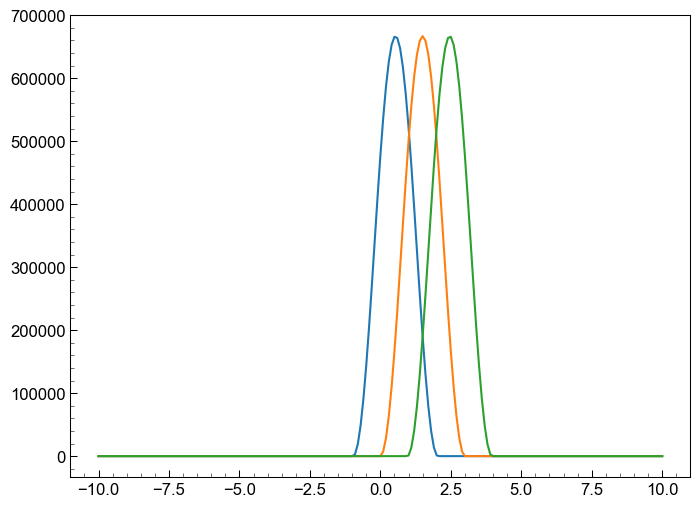

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(tvec*1e6, y1, tvec*1e6, y2, tvec*1e6, y3)

# Compute the sensor output by integrating the incident wave.

1. compute the sensor output with a given $T_R$
2. numerically evaluate the biased duration
3. store to the array

In [11]:
TR_list = np.arange(1e-6, 8e-6, step=1e-6)

NTR = len(TR_list)

theta = np.deg2rad(70) # common incident angle in the experimental setup

TR_biased = []
y_cos_all = np.zeros((NTR, len(tvec)))
y_integrated_all = np.zeros((NTR, len(tvec)))

for i, TR_test in enumerate(TR_list):
    print(f"start processing {TR_test:.2e}")
    y_cos =  stf_cosine(tvec, TR_test, 1)
    y_test = y_cosine_scaled_numeric(tvec, vp, theta, TR_test, R_sensor)

    # evaluate duration
    y_thresh = np.max(y_test)*1e-3 # find the threshold as 0.1 % of max STF value
    tmp_dur = np.where(y_test>y_thresh)[0]
    biased_duration = tvec[tmp_dur[-1]]-tvec[tmp_dur[0]]
    # store the data
    TR_biased.append(biased_duration)
    y_cos_all[i, :] = y_cos
    y_integrated_all[i, :] = y_test

start processing 1.00e-06
start processing 2.00e-06
start processing 3.00e-06
start processing 4.00e-06
start processing 5.00e-06
start processing 6.00e-06
start processing 7.00e-06


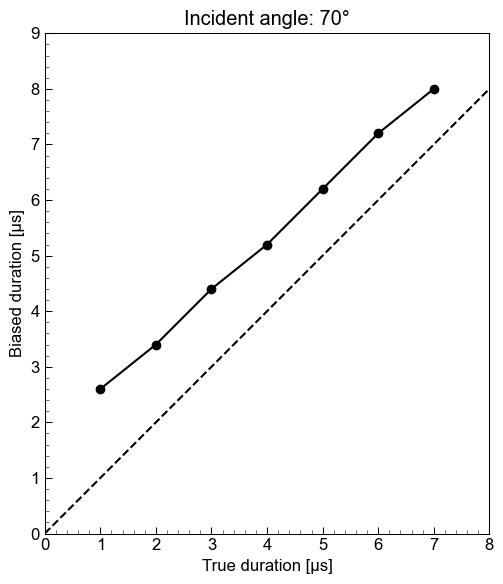

In [12]:
# plot the biased duration

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.array(TR_list)*1e6, np.array(TR_biased)*1e6, "ko-")
ax.plot([0, 10], [0, 10], "k--")
ax.set_xlim([0, 8.0])
ax.set_ylim([0, 9.0])
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("True duration [μs]")
ax.set_ylabel("Biased duration [μs]")

ax.set_title("Incident angle: {:.0f}°".format(np.rad2deg(theta)))
plt.tight_layout()
plt.savefig(figdir+f"/biased_duration_{np.rad2deg(theta):.0f}.png", format="png", dpi=70)
plt.savefig(figdir+f"/biased_duration_{np.rad2deg(theta):.0f}.eps")

(-1.0, 7.0)

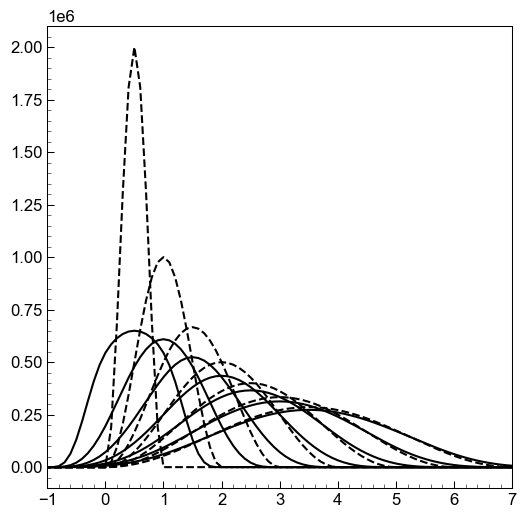

In [13]:
# Plot pulses

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i, TR_test in enumerate(TR_list):
    
    ax.plot(tvec*1e6, y_cos_all[i, :], "k--")
    ax.plot(tvec*1e6, y_integrated_all[i, :], "k-")
    
ax.set_xlim([-1.0, 7.0])

In [14]:
# plot for schematic of change in duration

2e-06
3e-06
4e-06


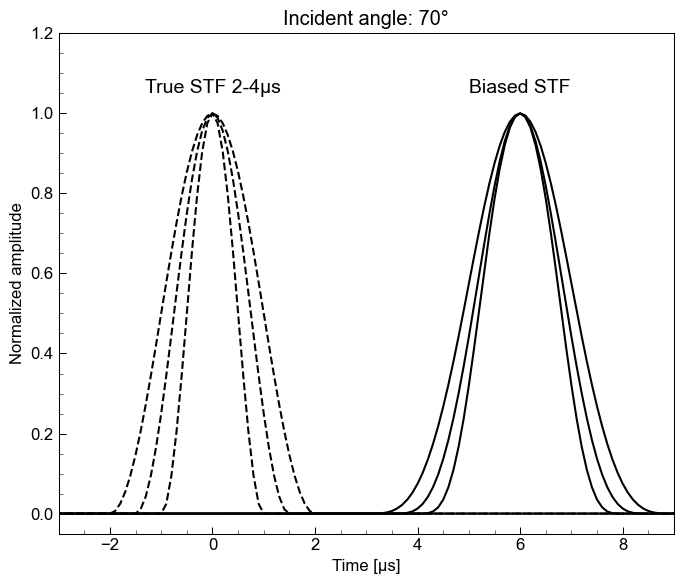

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

yshift_true_static = 10
yshift_true_biased = 16

for i in [1, 2, 3]:
    TR_test = TR_list[i]
    print(TR_test)
    # plot true stf
    y_true =  y_cos_all[i, :]
    maxind_true = y_true.argmax()
    tshift_true = dt*maxind_true
    
    ax.plot((tvec-tshift_true)*1e6 + yshift_true_static, y_true/y_true.max(), "k--")
    
    # plot biased stf
    y_biased =  y_integrated_all[i, :]
    maxind_biased = y_biased.argmax()
    tshift_biased = dt*maxind_biased
    
    ax.plot((tvec-tshift_biased)*1e6 + yshift_true_biased, y_biased/y_biased.max(), "k-")

    y_thresh = np.max(y_biased)*0.02
    tmp_dur = np.where(y_biased>y_thresh)[0]
    biased_duration = tvec[tmp_dur[-1]]-tvec[tmp_dur[0]]
    # ax.plot((np.array([tvec[tmp_dur[0]], tvec[tmp_dur[-1]]])-tshift_biased)*1e6+ yshift_true_biased, np.array([y_thresh, y_thresh])/y_biased.max(), "s" )
    
ax.set_title("Incident angle: {:.0f}°".format(np.rad2deg(theta)))
ax.set_xlim([-3.0, 9.0])
ax.set_ylim([-0.05, 1.2])
ax.set_xlabel("Time [μs]")
ax.set_ylabel("Normalized amplitude")

ax.text(0, 1.05, "True STF 2-4μs", ha="center", fontsize=14)
ax.text(6, 1.05, "Biased STF", ha="center", fontsize=14)

plt.tight_layout()
plt.savefig(figdir+f"/stf_true_and_biased_comparison_{np.rad2deg(theta):.0f}.png", format="png", dpi=150)
plt.savefig(figdir+f"/stf_true_and_biased_comparison_{np.rad2deg(theta):.0f}.eps", format="eps")

2e-06
3e-06
4e-06


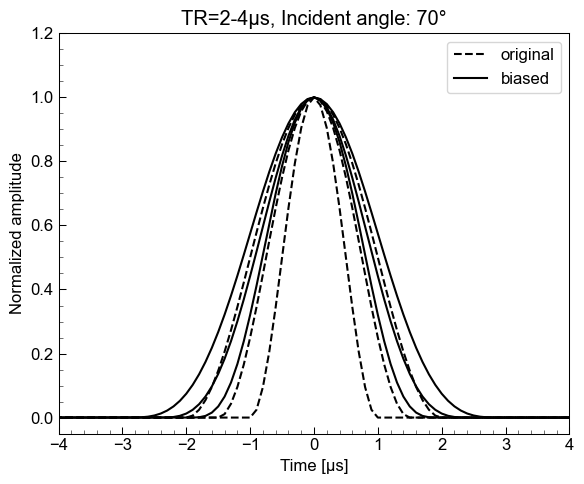

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

yshift_true_static = 10
yshift_true_biased = 10

for i in [1, 2, 3]:
    TR_test = TR_list[i]
    print(TR_test)
    # plot true stf
    y_true =  y_cos_all[i, :]
    maxind_true = y_true.argmax()
    tshift_true = dt*maxind_true
    
    h1, = ax.plot((tvec-tshift_true)*1e6 + yshift_true_static, y_true/y_true.max(), "k--")
    
    # plot biased stf
    y_biased =  y_integrated_all[i, :]
    maxind_biased = y_biased.argmax()
    tshift_biased = dt*maxind_biased
    
    h2, = ax.plot((tvec-tshift_biased)*1e6 + yshift_true_biased, y_biased/y_biased.max(), "k-")

    y_thresh = np.max(y_biased)*0.02
    tmp_dur = np.where(y_biased>y_thresh)[0]
    biased_duration = tvec[tmp_dur[-1]]-tvec[tmp_dur[0]]
    # ax.plot((np.array([tvec[tmp_dur[0]], tvec[tmp_dur[-1]]])-tshift_biased)*1e6+ yshift_true_biased, np.array([y_thresh, y_thresh])/y_biased.max(), "s" )
    
ax.set_title(f"TR={TR_list[1]*1e6:.0f}-{TR_list[3]*1e6:.0f}μs, Incident angle: {np.rad2deg(theta):.0f}°")
ax.set_xlim([-4.0, 4.0])
ax.set_ylim([-0.05, 1.2])
ax.set_xlabel("Time [μs]")
ax.set_ylabel("Normalized amplitude")

ax.legend([h1, h2], ["original", "biased"])
# ax.text(0, 1.05, "True STF 2-4μs", ha="center", fontsize=14)
# ax.text(6, 1.05, "Biased STF", ha="center", fontsize=14)

plt.tight_layout()
# plt.savefig(figdir+f"/stf_true_and_biased_comparison_{np.rad2deg(theta):.0f}.png", format="png", dpi=150)
# plt.savefig(figdir+f"/stf_true_and_biased_comparison_{np.rad2deg(theta):.0f}.eps", format="eps")

# Conclusion

1.	Although the pulse width may be biased when assuming uniform sensitivity on the sensor surface, the source duration can still be distinguished. Therefore, it is unlikely that the source duration is artificially aligned.

2.	The assumption of uniform sensitivity on the sensor surface may not always be valid (e.g., Monnier et al., 2012). In our case, the waveform generated by a ball-drop impact with a source duration of ~7 μs matches the modeled waveforms without considering the bias introduced by the aperture effect on source duration. Thus, the +1 μs bias shown in the figure above is likely overestimated. Further studies are needed to clarify the aperture effect on pulse width.